Mounted at /content/drive

Processing: Phoenix
Loaded: 150 rows
  Saved bundled Excel for Phoenix: /content/drive/MyDrive/Capstone/FinalData/phoenix_analysis_bundle.xlsx

Processing: Dallas
Loaded: 190 rows
  Saved bundled Excel for Dallas: /content/drive/MyDrive/Capstone/FinalData/dallas_analysis_bundle.xlsx

Processing: Memphis
Loaded: 76 rows
  Saved bundled Excel for Memphis: /content/drive/MyDrive/Capstone/FinalData/memphis_analysis_bundle.xlsx

Processing: Los_Angeles
Loaded: 270 rows
  Saved bundled Excel for Los_Angeles: /content/drive/MyDrive/Capstone/FinalData/los_angeles_analysis_bundle.xlsx

Cross-metro ACI summary saved to: /content/drive/MyDrive/Capstone/FinalData/aci_pressure_summary_all_metros.csv


/tmp/ipython-input-3280505680.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  combined.groupby(["City", "pressure_cat"], as_index=False)



Combined analysis bundle saved to: /content/drive/MyDrive/Capstone/FinalData/combined_analysis_bundle.xlsx

=== ALL ANALYSIS COMPLETE ===


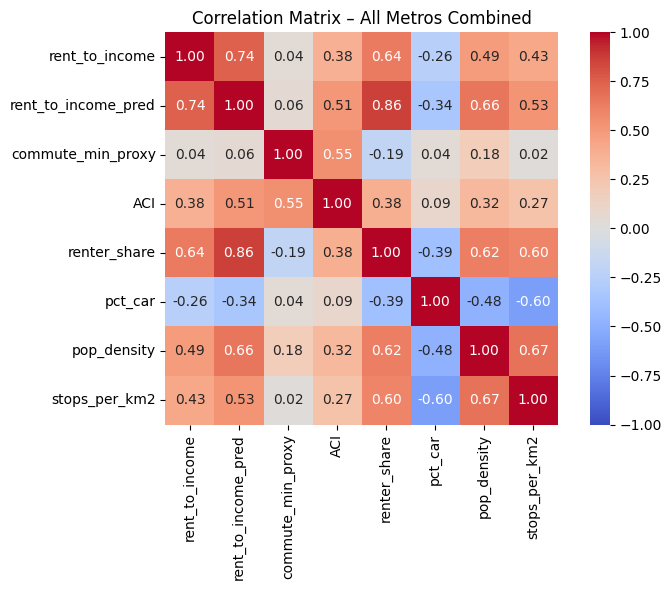

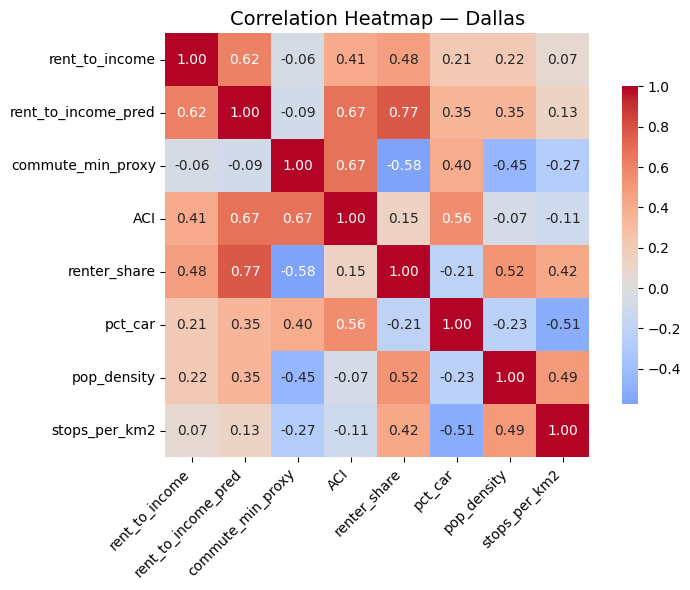

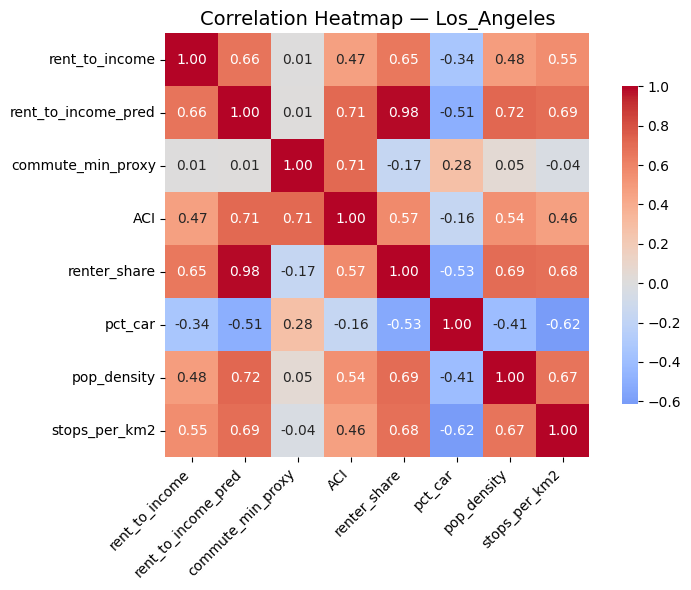

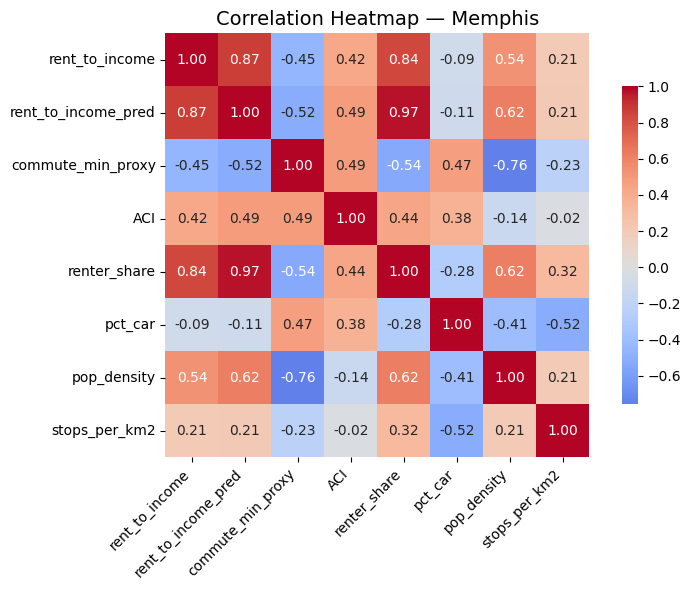

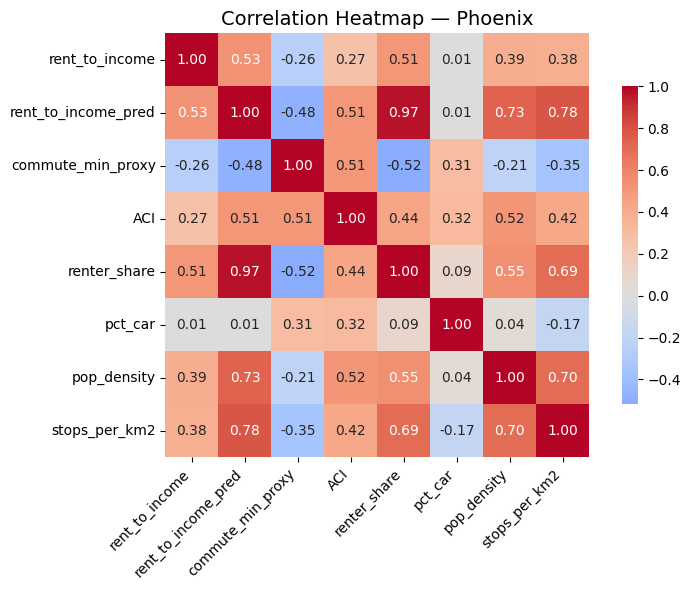

In [ ]:
import os
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import xlsxwriter

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

BASE_PATH = r"C:\Users\mstat\OneDrive\Desktop\EDA\Final Data"

METRO_FILES = {
    "Phoenix":     "final_zcta_dataset_phoenix_all.csv",
    "Dallas":      "final_zcta_dataset_dallas_all.csv",
    "Memphis":     "final_zcta_dataset_memphis_all.csv",
    "Los_Angeles": "final_zcta_dataset_los_angeles_all.csv",
}

def ensure_numeric(df, cols):
    df = df.copy()
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def run_rentburden_model_with_cv(df, city, n_splits=5):
    df = df.copy()
    required = ["rent_to_income","commute_min_proxy","renter_share","pct_car","pop_density"]
    df = ensure_numeric(df, required)
    df = df.dropna(subset=required)

    formula = (
        "rent_to_income ~ commute_min_proxy "
        "+ I(commute_min_proxy ** 2) "
        "+ renter_share + pct_car + pop_density"
    )

    full_model = smf.ols(formula, data=df).fit(cov_type="HC3")
    df["rent_to_income_pred"] = full_model.predict(df)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_rows = []
    fold_num = 1

    for train_idx, test_idx in kf.split(df):
        train = df.iloc[train_idx]
        test = df.iloc[test_idx]
        m = smf.ols(formula, data=train).fit()
        preds = m.predict(test)
        rmse = np.sqrt(mean_squared_error(test["rent_to_income"], preds))
        mae = mean_absolute_error(test["rent_to_income"], preds)
        r2  = r2_score(test["rent_to_income"], preds)
        cv_rows.append({
            "fold": fold_num,
            "rmse": rmse,
            "mae": mae,
            "r2": r2,
            "n_test": len(test)
        })
        fold_num += 1

    cv_results = pd.DataFrame(cv_rows)
    cv_summary = {
        "CV_RMSE_mean": cv_results["rmse"].mean(),
        "CV_MAE_mean":  cv_results["mae"].mean(),
        "CV_R2_mean":   cv_results["r2"].mean()
    }

    return full_model, df, cv_results, cv_summary

def compute_aci(df, city):
    df = df.copy()
    required = ["rent_to_income_pred", "commute_min_proxy"]
    df = ensure_numeric(df, required)
    df = df.dropna(subset=required)
    df["City"] = city

    df["rent_pred_z"] = (df["rent_to_income_pred"] - df["rent_to_income_pred"].mean()) / df["rent_to_income_pred"].std(ddof=0)
    df["commute_z"] = (df["commute_min_proxy"] - df["commute_min_proxy"].mean()) / df["commute_min_proxy"].std(ddof=0)

    df["ACI"] = df["rent_pred_z"] + df["commute_z"]

    df["pressure_cat"] = pd.qcut(
        df["ACI"].rank(method="first"),
        3,
        labels=["Low", "Medium", "High"]
    )

    return df

def run_aci_models(df, city):
    df = df.copy()
    required = ["ACI", "stops_per_km2"]
    df = ensure_numeric(df, required)
    df = df.dropna(subset=required)

    ols_model = smf.ols("ACI ~ stops_per_km2", data=df).fit(cov_type="HC3")

    qr_mod = smf.quantreg("ACI ~ stops_per_km2", data=df)
    quantiles = [0.25, 0.50, 0.75]

    rows = []
    qr_fits = {}

    for q in quantiles:
        res = qr_mod.fit(q=q)
        qr_fits[q] = res
        rows.append({
            "tau": q,
            "gamma_stops_per_km2": res.params.get("stops_per_km2"),
            "pvalue": res.pvalues.get("stops_per_km2")
        })

    qr_table = pd.DataFrame(rows)
    return ols_model, qr_fits, qr_table

def vif_table(df, features):
    X = df[features].dropna()
    return pd.DataFrame({
        "feature": features,
        "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    })

def descriptive(df, cols):
    return df[cols].describe().T

def correlations(df, cols):
    return df[cols].corr()

def model_metrics(model, name, city):
    return {
        "City": city,
        "Model": name,
        "R2": model.rsquared,
        "Adj_R2": model.rsquared_adj,
        "AIC": model.aic,
        "BIC": model.bic
    }

all_processed = []
all_metrics_tables = []

for city, filename in METRO_FILES.items():
    print("\n==========================")
    print("Processing:", city)
    print("==========================")

    path = os.path.join(BASE_PATH, filename)
    if not os.path.exists(path):
        print("!! File not found:", path)
        continue

    df_raw = pd.read_csv(path)
    print("Loaded:", len(df_raw), "rows")

    rent_model, df_rent, cv_results, cv_summary = run_rentburden_model_with_cv(df_raw, city)
    df_aci = compute_aci(df_rent, city)
    aci_ols, aci_qr_fits, aci_qr_table = run_aci_models(df_aci, city)

    rb_metrics = model_metrics(rent_model, "RentBurdenModel", city)
    rb_metrics.update(cv_summary)

    aci_metrics = model_metrics(aci_ols, "ACI_OLS", city)
    metrics_df = pd.DataFrame([rb_metrics, aci_metrics])
    all_metrics_tables.append(metrics_df)

    vif_cols = ["commute_min_proxy", "renter_share", "pct_car", "pop_density"]
    vif_df = vif_table(df_rent, vif_cols)

    desc_cols = [
        "rent_to_income", "rent_to_income_pred",
        "commute_min_proxy", "ACI",
        "renter_share", "pct_car", "pop_density", "stops_per_km2"
    ]

    desc_df = descriptive(df_aci, desc_cols)
    corr_df = correlations(df_aci, desc_cols)

    rent_coefs = pd.DataFrame({
        "param": rent_model.params.index,
        "coef": rent_model.params.values,
        "std_err": rent_model.bse.values,
        "pvalue": rent_model.pvalues.values
    })

    aci_coefs = pd.DataFrame({
        "param": aci_ols.params.index,
        "coef": aci_ols.params.values,
        "std_err": aci_ols.bse.values,
        "pvalue": aci_ols.pvalues.values
    })

    preds_df = df_aci[[
        "ZCTA5CE", "City",
        "rent_to_income", "rent_to_income_pred",
        "commute_min_proxy", "ACI", "pressure_cat",
        "stops_per_km2", "renter_share", "pct_car", "pop_density"
    ]]

    city_key = city.lower().replace(" ", "_")
    xlsx_path = os.path.join(BASE_PATH, f"{city_key}_analysis_bundle.xlsx")

    with pd.ExcelWriter(xlsx_path, engine="xlsxwriter") as writer:
        df_aci.to_excel(writer, sheet_name="data", index=False)
        metrics_df.to_excel(writer, sheet_name="metrics", index=False)
        rent_coefs.to_excel(writer, sheet_name="rent_model_coefs", index=False)
        aci_coefs.to_excel(writer, sheet_name="aci_ols_coefs", index=False)
        vif_df.to_excel(writer, sheet_name="vif", index=False)
        desc_df.to_excel(writer, sheet_name="descriptives")
        corr_df.to_excel(writer, sheet_name="correlations")
        aci_qr_table.to_excel(writer, sheet_name="aci_quantiles", index=False)
        preds_df.to_excel(writer, sheet_name="predictions", index=False)
        cv_results.to_excel(writer, sheet_name="cv_results", index=False)

    print(f"Saved Excel for {city}: {xlsx_path}")

    all_processed.append(df_aci)

combined = pd.concat(all_processed, ignore_index=True)

summary = (
    combined.groupby(["City", "pressure_cat"], as_index=False)
    .agg(
        mean_ACI=("ACI", "mean"),
        mean_pred_rent=("rent_to_income_pred", "mean"),
        mean_commute=("commute_min_proxy", "mean"),
        mean_transit=("stops_per_km2", "mean"),
        mean_renter_share=("renter_share", "mean"),
        mean_vehicle=("pct_car", "mean"),
        mean_density=("pop_density", "mean"),
        n_zctas=("ZCTA5CE", "nunique")
    )
)

summary_path = os.path.join(BASE_PATH, "aci_pressure_summary_all_metros.csv")
summary.to_csv(summary_path, index=False)
print("Cross-metro summary saved:", summary_path)

combined_desc = combined[[
    "rent_to_income", "rent_to_income_pred",
    "commute_min_proxy", "ACI",
    "renter_share", "pct_car", "pop_density", "stops_per_km2"
]].describe().T

combined_corr = combined[[
    "rent_to_income", "rent_to_income_pred",
    "commute_min_proxy", "ACI",
    "renter_share", "pct_car", "pop_density", "stops_per_km2"
]].corr()

combined_metrics_df = pd.concat(all_metrics_tables, ignore_index=True)

combined_preds = combined[[
    "City", "ZCTA5CE",
    "rent_to_income", "rent_to_income_pred",
    "commute_min_proxy", "ACI", "pressure_cat",
    "stops_per_km2", "renter_share", "pct_car", "pop_density"
]]

combined_xlsx_path = os.path.join(BASE_PATH, "combined_analysis_bundle.xlsx")

with pd.ExcelWriter(combined_xlsx_path, engine="xlsxwriter") as writer:
    combined.to_excel(writer, sheet_name="all_data", index=False)
    summary.to_excel(writer, sheet_name="aci_summary", index=False)
    combined_metrics_df.to_excel(writer, sheet_name="metrics", index=False)
    combined_desc.to_excel(writer, sheet_name="descriptives")
    combined_corr.to_excel(writer, sheet_name="correlations")
    combined_preds.to_excel(writer, sheet_name="predictions", index=False)

print("Combined analysis saved:", combined_xlsx_path)

plt.figure(figsize=(8, 6))
sns.heatmap(
    combined_corr,
    annot=True,
    cmap="coolwarm",
    vmin=-1, vmax=1, center=0,
    fmt=".2f",
    square=True
)
plt.title("Correlation Matrix – All Metros Combined")
plt.tight_layout()
plt.show()

for city, df_city in combined.groupby("City"):
    corr_city = df_city[[
        "rent_to_income", "rent_to_income_pred",
        "commute_min_proxy", "ACI",
        "renter_share", "pct_car", "pop_density", "stops_per_km2"
    ]].corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        corr_city,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        square=True,
        cbar_kws={"shrink": 0.75}
    )
    plt.title(f"Correlation Heatmap — {city}", fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
